In [ ]:
!pip install transformers
!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.3 MB/s eta 0:00:00
  Created wheel for sacremoses: filenam

In [ ]:
import torch
import torch.cuda
from google.colab import drive
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {'cuda' if torch.cuda.is_available() else 'cpu'}")

Mounted at /content/drive
Using cuda


In [ ]:
import pandas as pd
import torch
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import DataLoader
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
def preprocess(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['tweet'] = data['tweet'].str.lower()
    data['tweet'] = data['tweet'].str.replace(r'(@\S+)', r' ', regex=True)
    data['tweet'] = data['tweet'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['tweet'] = data['tweet'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['tweet'] = data['tweet'].str.replace('[^\w\s]', '')                                                       # remove special characters
    data['tweet'] = data['tweet'].replace('\d', '', regex=True)
    data['tweet'] = data['tweet'].str.replace(r'[^\x00-\x7F]+', r' ', regex=True) 
    
    i = 0
    for index, row in data.iterrows():
        text = row['tweet']
        #word_tokens = tokenizer.tokenize(text)
        token_id = tokenizerTweet.encode(text)
        #filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_.append({
            "index": i,
            "Class": row['task_2'],
            "Tweet": text,
            'Token_id': token_id
        }, ignore_index=True)
        i = i + 1
    return df_

In [ ]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
bertweet = bertweet.to(device)
tokenizerTweet= AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

data1 = pd.read_table('/content/drive/MyDrive/deepNN-labs/data/HASOCData/english_dataset.tsv')
data2 = pd.read_table('/content/drive/MyDrive/deepNN-labs/data/HASOCData/hasoc2019_en_test-2919.tsv')
columns = ['index', 'Tweet', 'Token_id','Class']
data = preprocess(data1, columns)

dataT = preprocess(data2, columns)


Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
data2.head(10)

In [ ]:
training_data = []

task1 = {'NOT': 0,
         'HOF': 1,}

task2 = {'NONE': 0,
         'HATE': 1,
         'OFFN': 2,
         'PRFN': 3}
#embed size 768

for _, n in data.iterrows():
    #print(n['index'])
    input_ids = torch.tensor([n['Token_id']]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-1]

    
    embeds = embeds.squeeze(0)
    #print(embeds.shape)
    training_data.append((embeds, task2[n['Class']]))

In [ ]:
testing_data = []

for _, n in dataT.iterrows():
    #print(n['index'])
    input_ids = torch.tensor([n['Token_id']]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-1]

    
    embeds = embeds.squeeze(0)
    #print(embeds.shape)
    testing_data.append((embeds, task2[n['Class']]))

In [ ]:
train_samp = int(0.8*len(training_data))
val_samp = len(training_data) - train_samp

train, val = torch.utils.data.random_split(training_data, [train_samp, val_samp], generator=torch.Generator())

dataloader = DataLoader(train, batch_size=32, shuffle=True)

val_loader = DataLoader(val, batch_size=32, shuffle=True)

In [ ]:
import torch.nn as nn
import torch.optim as optim

class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # change here
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # and here
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out



model = MyLSTM(768, 128, 4)
model = model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()


model.train()
for epoch in range(20):
    total = correct = 0
    # Training loop
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        print(inputs.shape)
        outputs = model(inputs)
        print(outputs.shape)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy
    train_accuracy = 100 * correct / total
    print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.2f}%'
          .format(epoch+1, num_epochs, loss.item(), train_accuracy))

    # Validation loop
    model.eval()  # switch model to evaluation mode
    with torch.no_grad():
        total = correct = 0
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        print('Validation Accuracy: {:.2f}%'.format(val_accuracy))

    model.train()  # switch model back to training mode



torch.Size([32, 768])


RuntimeError: ignored

In [ ]:
totalTest = 0
correctTest = 0
listPred = []
listTrue = []



for (embeds, label) in testing_data:
        embeds = embeds.unsqueeze(0)  # Add the batch dimension
        label = torch.tensor([label]).to(device)
        
        # Forward pass
        outputs = model(embeds)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Update total and correct counts
        totalTest += label.size(0)
        correctTest += (predicted == label).sum().item()
        for i in range(len(outputs)):
                listPred.append(predicted[i].cpu().item())
                listTrue.append(label[i].cpu().item())

accuracy = 100 * correctTest / totalTest
print(accuracy)

61.058109280138765


Confusion matrix, without normalization
[[607 105  49 104]
 [ 57  34  20  13]
 [ 28   7  13  23]
 [ 32   5   6  50]]


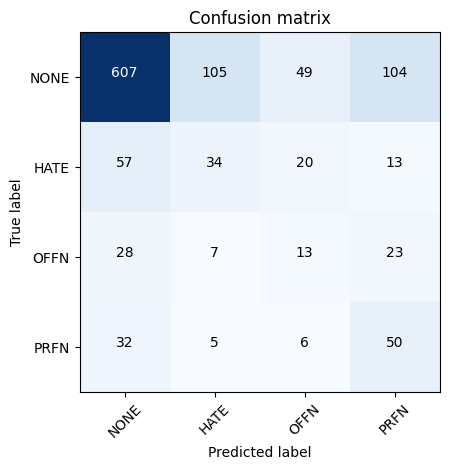

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(listTrue, listPred)
plot_confusion_matrix(cnf_matrix,task2)

In [ ]:
training_data = []
labels = {'NOT': 0,
         'HOF': 1,
}
#embed size 768

for _, n in data.iterrows():
    #print(n['index'])
    input_ids = torch.tensor([n['Token_id']]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-2]
    padd_size = (120 - len(n['Token_id']))
    
    #print(padd_size + len(n['Token_id']))

    padd_tens = torch.zeros((1, padd_size, 768))
    padd_tens = padd_tens.to(device)

    new_tens = torch.cat((embeds, padd_tens), dim=1)
    new_tens = new_tens.squeeze(0)

    training_data.append((new_tens, labels[n['Class']]))

testing_data = []


#embed size 768

for _, n in dataT.iterrows():
    #print(n['index'])
    input_ids = torch.tensor([n['Token_id']]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-2]
    padd_size = (120 - len(n['Token_id']))
    
    print(padd_size + len(n['Token_id']), " ", n['index'])

    padd_tens = torch.zeros((1, padd_size, 768))
    padd_tens = padd_tens.to(device)

    new_tens = torch.cat((embeds, padd_tens), dim=1)
    new_tens = new_tens.squeeze(0)

    testing_data.append((new_tens, labels[n['Class']]))

KeyboardInterrupt: ignored

In [ ]:
from torch.autograd import Variable

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.output_dim = output_dim #nr of classes
        self.num_layers = num_layers #nr of layers
        self.input_dim = input_dim #input size
        self.hidden_dim = hidden_dim #hidden state
        #self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
      #  lstm_out, _ = self.lstm(x)
       # out = self.fc(lstm_out[:, -1, :])
        #return out
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_dim)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_dim)).to(device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_dim)
        out = self.relu(hn)
        out = self.fc1(out)
        out = self.fc(out)
        return out

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(120, 128, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding=2)
        #nn.LSTM(input_dim = 256, hidden_dim = 400, num_layers = 1, batch_first=True, dropout=0.5, bidirectional = True)
        self.lstm = nn.LSTM(256, 400, 1, batch_first=True, dropout=0.5)

        self.fc1 = nn.Linear(400, 120)  # Adjust this dimension based on the output size from the previous layer
        self.fc2 = nn.Linear(120, 2)
        self.dropout = nn.Dropout(p=0.1)
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.conv1(x)
        x = F.tanh(x)
        x = self.pool(x)
        #x = self.dropout(x)
        x = self.conv2(x)
        x = F.tanh(x)
        x = self.pool(x)

        x = x.transpose(1,2)  
        h_0 = Variable(torch.zeros(1, x.size(0), 400)).to(device)
        c_0 = Variable(torch.zeros(1, x.size(0), 400)).to(device)
        #print("Innan: ", x.shape)
        x, (hn, cn) = self.lstm(x, (h_0, c_0))
        #cat = torch.cat((hn[-2, :, :], hn[-1, :, :]), dim=1)
        hn = hn.view(-1, 400)
        #print("Efter: ", x.shape)
        x = F.leaky_relu(hn)

        x = self.fc1(x)
        
        #x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        #x = self.softmax(x)
        return x

In [ ]:

def train_model(model, criterion, optimizer, lista, val, num_epochs):
    bestValLoss = 1000
    for epochs in range(num_epochs):
        loss = 0
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        running_loss2 = 0.0
        correct_predictions2 = 0
        total_predictions2 = 0

        for batch_nr, (data, label) in enumerate(lista):
            #print("Data, ", data, "\n Labels: ", labels, "\n batch: ", batch_nr)
            prediction = model.forward(data)
            _, predicted = torch.max(prediction, 1)

            #label = to_onehot(label).to(device)
            label = label.to(device)
            loss = criterion(prediction, label)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item() * data.size(0)
            correct_predictions += (predicted == label).sum().item()
            total_predictions += label.size(0)
        
        ##Validation
        for batch_nr, (data, label) in enumerate(lista):
            #print("Data, ", data, "\n Labels: ", labels, "\n batch: ", batch_nr)
            prediction = model.forward(data)
            _, predicted = torch.max(prediction, 1)

            label = label.to(device)
            loss = criterion(prediction, label)

            if (loss < bestValLoss):
                bestValLoss = loss
                torch.save(model, f="./test")
              
            running_loss2 += loss.item() * data.size(0)
            correct_predictions2 += (predicted == label).sum().item()
            total_predictions2 += label.size(0)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = correct_predictions / total_predictions

        epoch_loss2 = running_loss2 / len(val_loader.dataset)
        epoch_acc2 = correct_predictions2 / total_predictions2

        print(f"Epoch {epochs+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}")

        print(f"Epoch {epochs+1}/{num_epochs}, Val_Loss: {epoch_loss2:.4f}, Val_Acc: {epoch_acc2:.4f}")

def test(model, testData):
    model.eval()
    correct = 0
    total = 0
    listPred = []
    listTrue = []
    with torch.no_grad():
        for data, labels in testData:
            outputs = model.forward(data)
            _, pred = torch.max(outputs, 1)
            label = labels.to(device)
            correct += (pred == label).sum().item()
            for i in range(len(pred)):
                listPred.append(pred[i].cpu().item())
                #listPred.append(pred.data.cpu().numpy())
                listTrue.append(labels[i].cpu().item())
            total += label.size(0)

    print(correct/total)
    return listPred, listTrue

In [ ]:
LEARNING_RATE = 0.0001
to_onehot = nn.Embedding(4,4)
to_onehot.weight.data = torch.eye(4)
# Load our network
model = Net()
model = model.to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)




train_samp = int(0.8*len(training_data))
val_samp = len(training_data) - train_samp

train, val = torch.utils.data.random_split(training_data, [train_samp, val_samp], generator=torch.Generator())

dataloader = DataLoader(train, batch_size=32, shuffle=True)

val_loader = DataLoader(val, batch_size=32, shuffle=True)


# Define our optimizer

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE, weight_decay=0.0005)

# Train the model

trained_model = train_model(model, criterion, optimizer, dataloader, val, 20)


Epoch 1/20, Loss: 0.6755, Acc: 0.5932
Epoch 1/20, Val_Loss: 2.6780, Val_Acc: 0.6088
Epoch 2/20, Loss: 0.6686, Acc: 0.6088
Epoch 2/20, Val_Loss: 2.6614, Val_Acc: 0.6088
Epoch 3/20, Loss: 0.6601, Acc: 0.6106
Epoch 3/20, Val_Loss: 2.6313, Val_Acc: 0.6276
Epoch 4/20, Loss: 0.6495, Acc: 0.6268
Epoch 4/20, Val_Loss: 2.5635, Val_Acc: 0.6298
Epoch 5/20, Loss: 0.6357, Acc: 0.6396
Epoch 5/20, Val_Loss: 2.4648, Val_Acc: 0.6588
Epoch 6/20, Loss: 0.6166, Acc: 0.6676
Epoch 6/20, Val_Loss: 2.3602, Val_Acc: 0.6896
Epoch 7/20, Loss: 0.5882, Acc: 0.6954
Epoch 7/20, Val_Loss: 2.2209, Val_Acc: 0.7468
Epoch 8/20, Loss: 0.5383, Acc: 0.7285
Epoch 8/20, Val_Loss: 1.8511, Val_Acc: 0.7971
Epoch 9/20, Loss: 0.4685, Acc: 0.7889
Epoch 9/20, Val_Loss: 1.5303, Val_Acc: 0.8541
Epoch 10/20, Loss: 0.3926, Acc: 0.8355
Epoch 10/20, Val_Loss: 1.2067, Val_Acc: 0.8896
Epoch 11/20, Loss: 0.3176, Acc: 0.8708
Epoch 11/20, Val_Loss: 0.9515, Val_Acc: 0.9081
Epoch 12/20, Loss: 0.2405, Acc: 0.9088
Epoch 12/20, Val_Loss: 0.7595, Va

In [ ]:
tester = DataLoader(testing_data, batch_size=32, shuffle=False)
pred, true = test(model, tester)

0.611448395490026


In [ ]:
len(true)

37

Confusion matrix, without normalization
[[619 246]
 [202  86]]


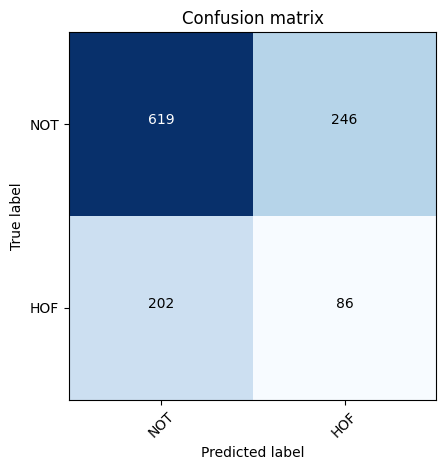

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(true, pred)
plot_confusion_matrix(cnf_matrix,labels)

In [ ]:
y_true = numpy.array([0, 0, 3, 0, 0, 0, 3, 3, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 1, 1, 3, 0, 0, 1, 0, 0, 2, 2, 0, 0])
y_pred = numpy.array([0, 2, 3, 1, 1, 0, 0, 3, 0, 2, 0, 1, 1, 2, 0, 3, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 3, 0, 0, 0])

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

In [ ]:
def embedder(text):
    
    token_ids = tokenizerTweet.encode(text)
    #print(token_ids)
    input_ids = torch.tensor([token_ids]).to(device)
    #print(input_ids)
    with torch.no_grad():
        features = bertweet(input_ids)
    embeds = features[-2]

    padd_size = (90 - len(token_ids))
    

    padd_tens = torch.zeros((1, padd_size, 768))
    padd_tens = padd_tens.to(device)

    new_tens = torch.cat((embeds, padd_tens), dim=1)
    #new_tens = new_tens.squeeze(0)
    
    return new_tens

t = embedder("Farewell SarahHuckabeeSanders Your lies for the asshole POTUS Will NEVER be missed. GladYourGone FuckTrump")

prediction = model.forward(t)

prediction

tensor([[ -57800.8203,  -67118.3125,  -75211.5625, -108935.4453]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
max = 0
id = 0
st = 0
for _, n in data.iterrows():
    print(len(n['Token_id']))
    if len(n['Token_id']) > max:
      max = len(n['Token_id'])
      id = n['index']
      st = n['Tweet']
print("Max: ", max, " index: ", id)